# Avaliação e Análise do Modelo CNN

Este script carregará o modelo treinado (`char_recognition_cnn.keras`), avaliará seu desempenho no conjunto de teste e fornecerá uma análise detalhada com exemplos de acertos e erros.

⚠️ **Pré-requisitos:** Certifique-se de que `char_recognition_cnn.keras` e `script_carregar_dados.py` estão no mesmo diretório. Você precisará das bibliotecas `tensorflow`, `numpy`, `sklearn` e `matplotlib` instaladas.

✅ Modelo 'char_recognition_cnn.keras' carregado com sucesso.
Found 51804 images belonging to 62 classes.
Found 7367 images belonging to 62 classes.
Found 7371 images belonging to 62 classes.

--- 2.1. Avaliação Quantitativa no Teste ---
231/231 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.8555 - loss: 0.3945

Loss (Perda) no Conjunto de Teste: 0.3945
Accuracy (Acurácia) no Conjunto de Teste: 0.8555
231/231 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step

--- 3.1. Relatório de Classificação (Acurácia, Precisão, Recall, F1-Score) ---
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       116
           1       0.94      0.79      0.86       111
           2       0.96      0.97      0.97       108
           3       0.99      0.99      0.99       106
           4       0.99      0.97      0.98       109
           5       1.00      0.98      0.99       109
           6       0.96      0.99      0.98       109
           7       0.94      1.00     

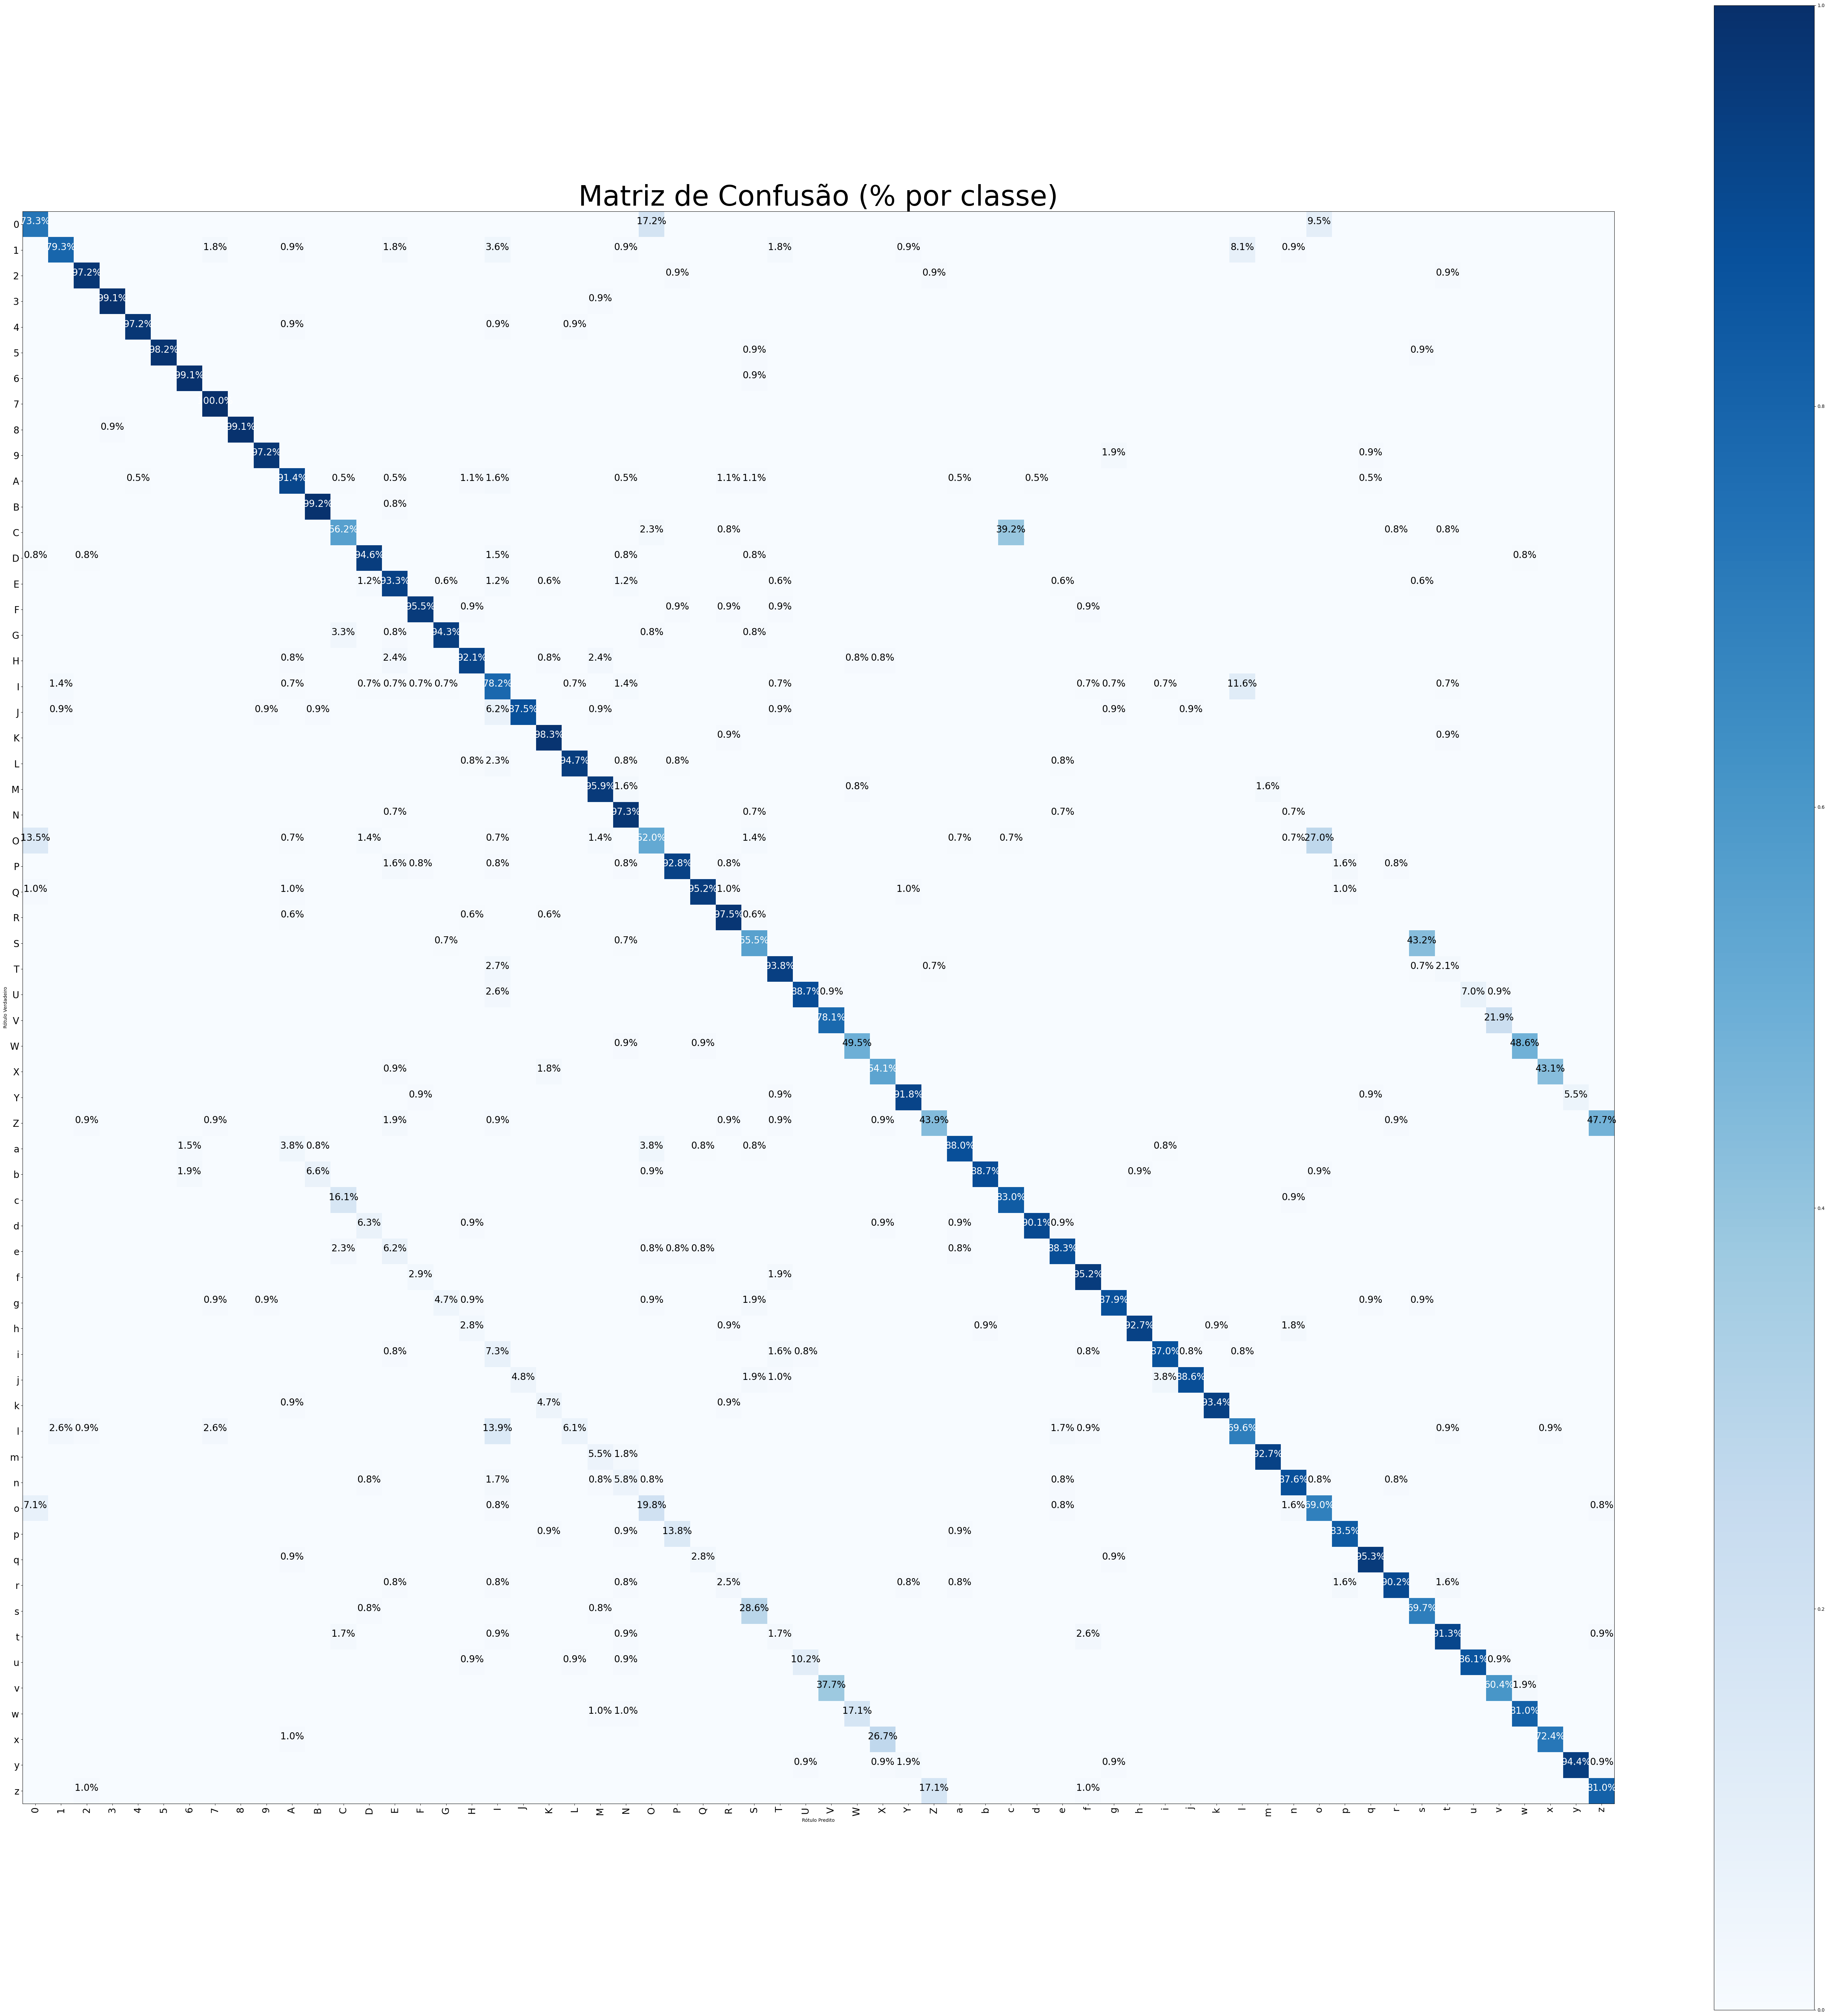


--- 4.1. Exemplos de ACERTOS (Modelo se saiu bem) ---


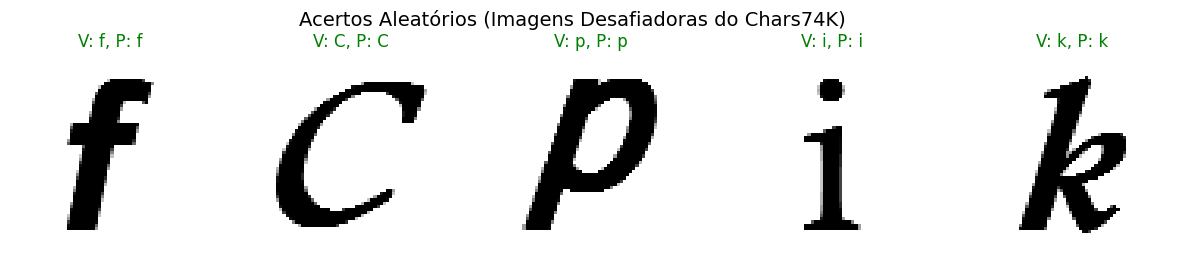


--- 4.2. Exemplos de ERROS (Modelo falhou) ---


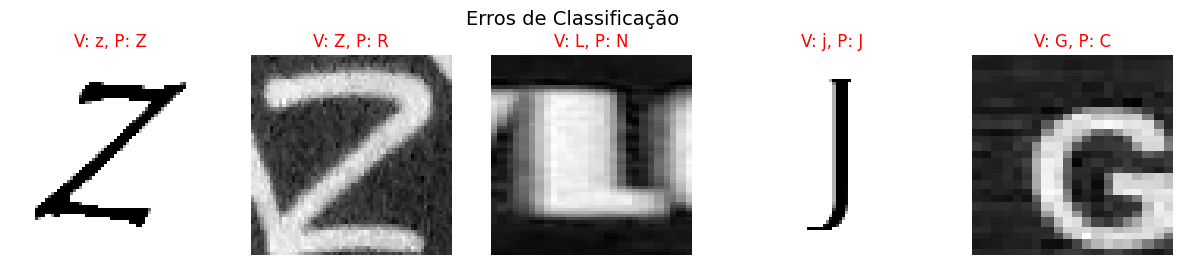



--- 5. ANÁLISE E DISCUSSÃO ---
5.1. Discussão de Causas de Erro:
Erros de confusão são comuns entre classes visualmente semelhantes (homoglíficas):
* **Dígitos vs. Letras:** Confusão entre '0' (zero) e 'O' (maiúsculo), '1' (um) e 'l' (L minúsculo) ou 'I' (i maiúsculo).
* **Letras Similares:** Confusão entre 'b' e 'd' (invertidos), 'p' e 'q' (invertidos) ou 'W' e 'M' (de ponta-cabeça).
* **Imagens Naturais:** Ruído de fundo, iluminação ruim e fontes incomuns no subconjunto `EnglishImg` aumentam a dificuldade.

5.2. Sugestões de Melhoria:
* **Arquitetura:** Usar um modelo mais profundo ou pré-treinado (Transfer Learning com VGG16 ou ResNet).
* **Data Augmentation:** Ajustar ou adicionar técnicas específicas, como rotação de 180 graus (para 'b'/'d' e 'p'/'q') ou técnicas de normalização de contraste.
* **Balanceamento de Dados:** Analisar o `classification_report` e, se alguma classe tiver F1-score baixo, balancear a proporção dos dados (usando pesos de classe ou sub-amostragem).
* **Pr

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import os
from script_carregar_dados import create_generators

# --- 1. CONFIGURAÇÕES E CARREGAMENTO ---
DATASET_PATH = 'chars74k_dataset_final'
MODEL_NAME = 'char_recognition_cnn.keras' 

# 1.1. Carregar o Modelo
try:
    model = tf.keras.models.load_model(MODEL_NAME)
    print(f"✅ Modelo '{MODEL_NAME}' carregado com sucesso.")
except Exception as e:
    print(f"❌ Erro ao carregar o modelo. Verifique se o arquivo existe. Erro: {e}")
    exit()

# 1.2. Gerar o Teste Generator (com shuffle=False)
# Usamos o create_generators para garantir que o pré-processamento seja idêntico ao do treinamento.
_, _, test_gen = create_generators(DATASET_PATH)

# O Keras infere os nomes das classes (rótulos) do diretório
class_labels = list(test_gen.class_indices.keys())
NUM_CLASSES = len(class_labels)

# --- 2. AVALIAÇÃO DO DESEMPENHO NO CONJUNTO DE TESTE ---

print("\n--- 2.1. Avaliação Quantitativa no Teste ---")
# loss, accuracy = model.evaluate(test_gen, steps=test_gen.samples // test_gen.batch_size, verbose=1)
loss, accuracy = model.evaluate(test_gen, verbose=1)

print(f"\nLoss (Perda) no Conjunto de Teste: {loss:.4f}")
print(f"Accuracy (Acurácia) no Conjunto de Teste: {accuracy:.4f}")

# 2.2. Obter Previsões e Rótulos Verdadeiros
# Resetar o generator para garantir que as previsões correspondam aos rótulos verdadeiros
# Previsão correta do dataset inteiro
test_gen.reset()  # garante ordem correta
Y_pred = model.predict(test_gen)

# Converter probabilidades em classes
y_pred = np.argmax(Y_pred, axis=1)

# Todos os rótulos verdadeiros (sem truncar)
y_true = test_gen.classes


# --- 3. GERAÇÃO DE MÉTRICAS DETALHADAS ---

print("\n--- 3.1. Relatório de Classificação (Acurácia, Precisão, Recall, F1-Score) ---")
print(classification_report(y_true, y_pred, target_names=class_labels, zero_division=0))


# 3.2. Matriz de Confusão com % internas
cm = confusion_matrix(y_true, y_pred)

# Converter para porcentagens por linha (acurácia por classe)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(60, 60))  # 🔥 imagem grande — boa leitura para 62 classes!
plt.imshow(cm_percent, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão (% por classe)', fontsize=60)
plt.colorbar()

tick_marks = np.arange(NUM_CLASSES)
plt.xticks(tick_marks, class_labels, rotation=90, fontsize=20)
plt.yticks(tick_marks, class_labels, fontsize=20)

# Inserir porcentagens dentro das células
thresh = cm_percent.max() / 2.
for i in range(cm_percent.shape[0]):
    for j in range(cm_percent.shape[1]):
        value = cm_percent[i, j]
        if value > 0:  # evitar zeros
            plt.text(j, i, f"{value*100:.1f}%", 
                     horizontalalignment="center",
                     color="white" if value > thresh else "black",
                     fontsize=20)

plt.xlabel('Rótulo Predito')
plt.ylabel('Rótulo Verdadeiro')
plt.tight_layout()
plt.show()


# --- 4. ANÁLISE QUALITATIVA (Acertos e Erros) ---

# Converter índices para rótulos para exibição
y_true_labels = [class_labels[i] for i in y_true]
y_pred_labels = [class_labels[i] for i in y_pred]

# Obter o caminho completo de todos os arquivos de teste
test_filenames = [os.path.join(DATASET_PATH, 'test', test_gen.filenames[i]) for i in range(len(y_pred))]


def plot_examples(indices, title, max_examples=5):
    """Função auxiliar para plotar exemplos de acertos/erros."""
    fig, axes = plt.subplots(1, min(max_examples, len(indices)), figsize=(15, 3))
    fig.suptitle(title, fontsize=14)
    
    for i, idx in enumerate(indices[:max_examples]):
        img = tf.keras.utils.load_img(test_filenames[idx], color_mode='grayscale', target_size=test_gen.target_size)
        img_array = tf.keras.utils.img_to_array(img)
        
        # O tensor de imagem é normalizado pelo datagen antes da previsão,
        # mas aqui carregamos para visualização (apenas redimensionado e em tons de cinza)
        
        ax = axes[i] if min(max_examples, len(indices)) > 1 else axes
        ax.imshow(img_array[:, :, 0], cmap='gray')
        
        true_label = y_true_labels[idx]
        pred_label = y_pred_labels[idx]
        
        ax.set_title(f"V: {true_label}, P: {pred_label}", color='green' if true_label == pred_label else 'red')
        ax.axis('off')
    plt.show()

# 4.1. Exemplos de ACERTOS Desafiadores (Para fins práticos, selecionamos acertos aleatórios)
correct_indices = np.where(y_true == y_pred)[0]
np.random.shuffle(correct_indices)
print("\n--- 4.1. Exemplos de ACERTOS (Modelo se saiu bem) ---")
plot_examples(correct_indices, "Acertos Aleatórios (Imagens Desafiadoras do Chars74K)")


# 4.2. Exemplos de ERROS (Modelo errou)
error_indices = np.where(y_true != y_pred)[0]
np.random.shuffle(error_indices)
print("\n--- 4.2. Exemplos de ERROS (Modelo falhou) ---")
plot_examples(error_indices, "Erros de Classificação", max_examples=5)

# --- 5. DISCUSSÃO (Análise de Resultados e Melhorias) ---

print("\n\n--- 5. ANÁLISE E DISCUSSÃO ---")

# 5.1. Discussão de Causas de Erro
print("5.1. Discussão de Causas de Erro:")
print("Erros de confusão são comuns entre classes visualmente semelhantes (homoglíficas):")
print("* **Dígitos vs. Letras:** Confusão entre '0' (zero) e 'O' (maiúsculo), '1' (um) e 'l' (L minúsculo) ou 'I' (i maiúsculo).")
print("* **Letras Similares:** Confusão entre 'b' e 'd' (invertidos), 'p' e 'q' (invertidos) ou 'W' e 'M' (de ponta-cabeça).")
print("* **Imagens Naturais:** Ruído de fundo, iluminação ruim e fontes incomuns no subconjunto `EnglishImg` aumentam a dificuldade.")

# 5.2. Sugestões de Melhoria
print("\n5.2. Sugestões de Melhoria:")
print("* **Arquitetura:** Usar um modelo mais profundo ou pré-treinado (Transfer Learning com VGG16 ou ResNet).")
print("* **Data Augmentation:** Ajustar ou adicionar técnicas específicas, como rotação de 180 graus (para 'b'/'d' e 'p'/'q') ou técnicas de normalização de contraste.")
print("* **Balanceamento de Dados:** Analisar o `classification_report` e, se alguma classe tiver F1-score baixo, balancear a proporção dos dados (usando pesos de classe ou sub-amostragem).")
print("* **Pré-processamento:** Tentar binarização (preto e branco) ou outras técnicas de realce para isolar o caractere em imagens naturais antes de alimentar a CNN.")